## This notebook performs the analysis and generates the figures for the paper
#### "Wind-driven variability in the prereversal enhancement: Climatologies observed by ICON" by Harding et al. (2024), JGR Space Physics

This was developed on Python 3.7.

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('figure',dpi=100)
from datetime import datetime, timedelta
import os
import glob
from scipy import interpolate, integrate

import pandas as pd
import xarray as xr
import seaborn as sns
import importlib
import requests

import apexpy
import gc


# This allows for printing running counters
import sys
import time as time_module
from IPython.display import display, clear_output
def printerase(s):
    clear_output(wait=True)
    time_module.sleep(0.01)
    print(s)
    sys.stdout.flush()
    
plt.style.use('seaborn')

# 1. Load IVM data

This downloads and reads a file which contains a reduced dataset, generated from the full IVM v6 dataset. This file was created by concatenating IVM data from the entire ICON mission, converting to apex coordinates, and computing 24-hour running means of the vertical drift (see text).

In [3]:
# This is a several GB file so downloading could take ~10 min or more.
url = 'https://research.ssl.berkeley.edu/~bharding/papers/Harding2024_PRE/ivm_v06d.h5'
local_filename = 'ivm_v06d.h5'

print('Downloading....')
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(local_filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):  
            file.write(chunk)
print('Done.')

In [4]:
# Read IVM file. This takes a few minutes.
dfivm = pd.read_hdf('ivm_v06d.h5')

# 2. Add F10.7 

Download the ICON geophysical indices file and add F10.7 to the dataset

In [36]:
url = 'https://research.ssl.berkeley.edu/~bharding/papers/Harding2024_PRE/icon_gpi.NC'
local_filename = 'icon_gpi.NC'

print('Downloading....')
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(local_filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):  
            file.write(chunk)
print('Done.')

Downloading....
Done.


In [37]:
def get_gpi(gpi_fn, start_idx = 1700):
    '''
    Load the ICON GPI file into an xarray.Dataset
    
    start_idx = Where to start. Index 1700 (default) corresponds to 2019 Nov
    '''
    
    dsgpi = xr.open_dataset(gpi_fn)
    dsgpi = dsgpi.isel(ndays=slice(start_idx,None)) # Start around 2019 Nov

    tgpi = pd.to_datetime([datetime(int(str(yd)[:4]),1,1) + timedelta(days=int(str(yd)[4:])-1) for yd in dsgpi.year_day.values])

    # Build dataframe
    t = []
    kp = []
    ap = []
    f107 = []
    for j in range(8):
        t.extend(tgpi + pd.to_timedelta(j*3 + 1.5, unit='H')) # hour offset
        kp.extend(dsgpi.kp.isel(nkp=j).values)

    ds = xr.Dataset({'kp':(['time'],kp)}, coords={'time':t} )

    # Create a separate dataset for the daily variables, then interpolate to the 3-hour times
    ds0 = xr.Dataset({
                      'ap':   (['time'],dsgpi.ap.values),
                      'f107': (['time'],dsgpi.f107d.values),
                     }, coords={'time':tgpi} )
    ds0['f107a'] = ds0.f107.rolling(time=81, center=True, min_periods=1).mean()
    dsgpi.close()

    # Interpolate and merge
    ds = xr.merge([ds, ds0.interp(time=ds.time)])
    
    return ds

In [38]:
dsgpi = get_gpi('icon_gpi.NC')

dsi = dsgpi.interp(time=dfivm.index, method='nearest')
dfivm['f107'] = dsi.f107
dfivm['kp'] = dsi.kp

## 3. Make Fig 1 (summary PRE figure)

In [39]:
# NaN low quality data
hiqual = (dfivm.iv_rpa_flag == 0) & (dfivm.iv_dm_flag == 0)
dfivm.loc[~hiqual,'iv_mer_mr'] = np.nan

# Smooth the meridional drifts to create a new variable which is downsampled to ~30 sec resolution
dfivmr = dfivm.iv_mer_mr.rolling(6, center=True, min_periods=3)
# dfivm.loc[:,'iv_mer_mr_med'] = dfivmr.median()
dfivm.loc[:,'iv_mer_mr_med'] = dfivmr.mean()

# Add a counter for each orbit
jump = dfivm.iv_sc_slt.diff() < 0
dfivm.loc[:,'orbit'] = np.cumsum(jump)

In [40]:
## Find orbits where the S/C crosses the mag equator near sunset
dfi = dfivm.iloc[::1] # for speed
sza_target = 98.
mag_lat_target = 0.0
idx = (abs(dfi.iv_sc_sza - sza_target) < 0.2) & (abs(dfi.iv_mag_lat) < 5.) & (dfi.iv_sc_slt > 12) # ensure it's a sunset not sunrise
# idx = (abs(dfi.iv_sc_sza - sza_target) < 6) & (abs(dfi.iv_mag_lat) < 0.5) & (dfi.iv_sc_slt > 12) # ensure it's a sunset not sunrise
orbits = dfi.orbit.loc[idx].unique()
print('%i orbits where ICON crosses mag equator near sunset, in DataFrame dfi' % len(orbits))
dfi = dfivm.loc[dfivm.orbit.isin(orbits)]

1753 orbits where ICON crosses mag equator near sunset, in DataFrame dfi


<IPython.core.display.Javascript object>


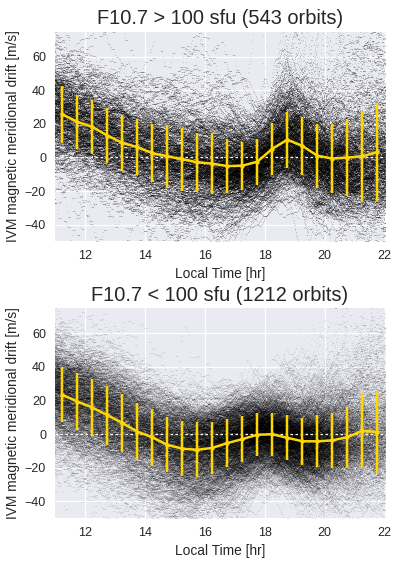

0.32070770406940896 1.0382341785071243 0.5091169657859572
F107: 76
0.5126526119462853 1.3522008601455777 0.7908219674906692
F107: 127


In [41]:
fvec = [60, 100, dfi.f107.max()] # Boundaries (edges) of f10.7 bins
Nf = len(fvec) - 1

plt.figure(figsize=(5,3.5*Nf))

for i in range(Nf):
    
    f0 = fvec[i]
    f1 = fvec[i+1]
    
    dfi0 = dfi.loc[(dfi.f107 > f0) & (dfi.f107 <= f1)]
    Norbits = len(pd.unique(dfi0.orbit))
    
    # Groupby slt
    sltbe = np.arange(11,22.01,0.5)
    sltb = (sltbe[1:] + sltbe[:-1])/2.
    dsg = dfi0.iloc[::20].to_xarray().groupby_bins('iv_sc_slt', sltbe) # Downsample for speed
    dsm = dsg.mean()
    dss = dsg.std()
    dsc = dsg.count()
    dsstderr = dss/np.sqrt(dsc)
    
    
    plt.subplot(Nf,1,Nf-i)
    ms = [0.4, 0.6][i] # Different scale sizes because there are different number of orbits
    plt.plot(dfi0.iv_sc_slt, dfi0.iv_mer_mr_med, 'k.', ms=ms, alpha=0.7)
    plt.axhline(y=0, color='w', lw=1, dashes=(2,2))
    plt.errorbar(sltb, dsm.iv_mer_mr_med, yerr=dss.iv_mer_mr_med, fmt='.-', lw=2, color='gold', zorder=5)
#     plt.errorbar(sltb, dsm.iv_mer_mr_med, yerr=dsstderr.iv_mer_mr_med, fmt='.-', lw=2, color='gold', zorder=5)
    plt.ylim((-50, 75))
    plt.xlim((11, 22))
    # plt.title('Each line is an orbit where ICON passes mag equator near sunset')
    plt.xlabel('Local Time [hr]')
    plt.ylabel('IVM magnetic meridional drift [m/s]')
#     plt.title('%.0f < F10.7 < %.0f   (%i orbits)' % (f0, f1, Norbits), fontsize=16)
    plt.title(['F10.7 < 100 sfu','F10.7 > 100 sfu'][i] +   ' (%i orbits)' % (Norbits), fontsize=16)
    
    
    # Print info for the caption
    s = dsstderr.iv_mer_mr_med
    print(s.min().item(), s.max().item(), s.mean().item())
    
    # print F10.7 mean
    print('F107: %.0f' % (dfi0.f107.mean()))

plt.tight_layout()
# plt.savefig('/home/bharding/public_html/papers/Harding2024_PRE/figs/fig1.pdf', bbox_inches='tight')
# plt.savefig('/home/bharding/public_html/papers/Harding2024_PRE/figs/fig1.png', dpi=1200, bbox_inches='tight')


## 4. Modeling

The modeling takes a few hours to process. Instead of including the code here, I've included it in a separate notebook. That separate notebook saves a .nc file which is loaded here and used for making plots. Also note that several tens of GB of RAM were required to run that code on my machine.

In this notebook, I'll just load the previously computed model output.

In [42]:
url = 'https://research.ssl.berkeley.edu/~bharding/papers/Harding2024_PRE/tiegcm_2024_v05.nc'
local_filename = 'tiegcm_2024_v05.nc'

print('Downloading....')
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(local_filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):  
            file.write(chunk)
print('Done.')

Downloading....
Done.


In [43]:
fn = 'tiegcm_2024_v05.nc'
dall = xr.open_dataset(fn)

In [44]:
slt_targ = 18.5 # Use this to define "longitude" for comparison with data
alt_targ = 766e3 # to match data

# Note this is the Kil 09 LTs, taken because the TIEGCM sometimes has a later PRE. (The IVM climatology comparison is done using 18-19 for Huang Hairston b/c solar min)
slt_min = 17.5
slt_max = 19.5

In [45]:
# Reindex into geographic lon (glon) for comparison to data
mlon = dall.mlon.mean(dim=['doy']).interp(slt=slt_targ) # Need to reindex UT into glon for comparison with data
mlond = mlon*180/np.pi
apex_obj = apexpy.Apex(date=2021, refh=dall.hR/1e3)
glat, glon, _ = apex_obj.qd2geo(0,mlond,alt_targ/1e3) # Using qd here because it's extremely close (theoretically the same) and easier to calculate
dall['lon']   = (['ut'],glon) # NOTE: This is longitude at the slt_targ, just like how it's done in the data (as long slt_targ is the same)
dall_lon   = dall.swap_dims({'ut':'lon'}).sortby('lon')

- dall_lon and dallyr_lon are the longitude variables to use from now on

- Note this is where we negate ve2 (apex coords) in order to define the PRE as positive upward

In [46]:
# Extract the mlat/apexht and LT of the PRE
mlat_idxd = abs(dall_lon.hA - alt_targ).argmin() # Closest to target apex height in dynamo code
mlatd = dall_lon.mlatd[mlat_idxd] # mag lat of that point in degrees

mod_amp = -dall_lon.sel(slt=slice(17.5,19.5)).ve2N.isel(mlat=mlat_idxd).max(dim='slt')


#### Setup a dataset "ds" that will store everything needed for further plots

In [47]:
ds = xr.Dataset({'mod_amp': mod_amp.drop(['time','ut'])})

In [48]:
# Figure out lon bin edges (calculated from the lon bin centers)
lonb = ds.lon.values
lonbfull = np.nan * np.zeros(len(lonb)+2)
lonbfull[1:-1] = lonb
lonbfull[0] = lonb[0] - (lonb[1]-lonb[0])
lonbfull[-1] = lonb[-1] + (lonb[-1]-lonb[-2])
lonbe = (lonbfull[1:] + lonbfull[:-1])/2. # This goes from -179.4 to +180.6. Adjust to -180 - +180 (longitude sampling is not even anyway)
lonbe[0] = -180.
lonbe[-1] = 180.

# Same for doy
doyb = ds.doy.values
doybfull = np.nan * np.zeros(len(doyb)+2)
doybfull[1:-1] = doyb
doybfull[0] = doyb[0] - (doyb[1]-doyb[0])
doybfull[-1] = doyb[-1] + (doyb[-1]-doyb[-2])
doybe = (doybfull[1:] + doybfull[:-1])/2. # This is exact (no need for adjustment above, which was due to mag geometry)


## 5. PRE strength vs longitude and season

In [50]:

def groupbin(df, col='los_wind', describe='50%', colx='slt', coly='lat', nx=24, ny = 20, countthresh = 5, dropna=True):
    '''
    Bin a dataset into 2D bins and return a single descriptive statistic for each bin.
    This is fairly self-explanatory, but effort was taken to ensure that if
    specific bins are requested, the returned DataFrame has all of those bins, even if they are empty. This
    is not how pd.groupby normally works.
   
    INPUTS:
    - df = pandas DataFrame with all of the data
    - col = the column name of the variable you want to bin
    - describe: '50%', '25%', 'mean', 'std', 'count', etc... whatever is returned by groupby(...).describe()
                'total_count' is an additional option, which is like "count" but includes nans (so the total # of samples). Not clear if this matters.
    - colx = the column name of one of the bin variables (i.e., one of the coordinates you are binning over)
    - coly = same, but for the second bin variable
    - nx and ny: ints or arrays
        - ints: number of bins. The bins will be automatically generated and results trimed to only include bins where there are data
        - arrays: edges of bins. Using this input will force the shape of the returned table to be the size of these arrays (minus 1)
    - dropna (default True): whether to include nans -- propagated to groupby
   
    OUTPUTS:
    x, y, p
    x: 1D bin edges
    y: 1D bin edges
    p: 2D values
    '''
   
    specify_bins = hasattr(nx, '__len__') # If true, use specific bins set by the user
   
    if specify_bins:
        xint = pd.IntervalIndex.from_arrays(nx[:-1], nx[1:]) # This includes "unobserved" columns
        yint = pd.IntervalIndex.from_arrays(ny[:-1], ny[1:])
       
        cut_x, _ = pd.cut(df[colx], bins=xint, retbins=True)
        cut_y, _ = pd.cut(df[coly], bins=yint, retbins=True)
    else:
        cut_x, _ = pd.cut(df[colx], bins=nx, retbins=True)
        cut_y, _ = pd.cut(df[coly], bins=ny, retbins=True)
   
    g = df[col].groupby([cut_x, cut_y], dropna=dropna)
    c = g.describe()
    if describe == 'total_count':
        c['total_count'] = g.apply(lambda x: len(x))
    i = c['count'] < countthresh
    c.loc[i,:] = np.nan
    p = c.pivot_table(index = c.index.get_level_values(1), columns=c.index.get_level_values(0)) # pivot table containing each variable
    p2 = p[describe]
   
    if specify_bins: # Re-index and re-column so that all requested bins are represented, even if they are empty
        p3 = pd.DataFrame(index=yint, columns=xint, dtype=float) # This is the "full sized" version of p2
        for i, idx in enumerate(yint):
            for j, col in enumerate(xint):
                try:
                    p3.loc[idx,col] = p2.loc[idx,col]
                except Exception as e:
                    pass    
        p2 = p3 # Overwrite p2
       
    # Coordinate axes, of size nx+1 and ny+1 (for plotting with pcolormesh)
    x = np.concatenate(([c.left for c in p2.columns], [p2.columns[-1].right]))
    y = np.concatenate(([c.left for c in p2.index],   [p2.index[-1].right]))
   
    return x, y, p2


In [51]:
# Note this is the Kil 09 LTs, taken because the TIEGCM sometimes has a later PRE. (The IVM climatology comparison is done using 18-19 for Huang Hairston b/c solar min)
slt_min = 17.5
slt_max = 19.5

data_mlat_max = 15. # # Note this is qdlat. The model apparently uses apex lat, so be careful


In [52]:

# Only keep the important variables, simplify naming
dfi = pd.DataFrame(index=dfivm.index, data = {'slt':dfivm.iv_sc_slt,
                                              've2':dfivm.iv_ve2_mr, # Note the choice of 24h-median-removed data following Wu et al and Heelis et al.
                                              'mag_lat':dfivm.iv_mag_lat,
                                              'mag_lon':dfivm.iv_mag_lon,
                                              'lon'    :dfivm.iv_sc_lon,
                                              'dm_flag':dfivm.iv_dm_flag,
                                              'rpa_flag':dfivm.iv_rpa_flag,
                                              'apex_ht' : dfivm.iv_apex_ht,
                                             })

good_data = (dfi.dm_flag==0) & (dfi.rpa_flag==0)
dfi = dfi.loc[good_data & (abs(dfi.mag_lat) < data_mlat_max)]

# Change lon to -180 to 180
dfi['mag_lon'] = np.mod(dfi.mag_lon + 180, 360)-180
dfi['lon'] = np.mod(dfi.lon + 180, 360)-180

# Only keep the required LTs
dfi = dfi.loc[(dfi.slt > slt_min) & (dfi.slt < slt_max)]

# Add doy for sorting
dfi['doy'] = dfi.index.dayofyear

In [53]:
dfi.apex_ht.mean()

765.9073188723733

In [54]:
# Compute MAX drift in 17.5-19.5 LT, on a per-bin basis. This matches Kil et al (2009)'s metric and matches the modeling analysis
# Use the same LT cadence as the model (though I don't think this is super important)
sltbe = np.arange(17.5, 19.50001, 0.25) # 15-min LT bins
sltb = (sltbe[1:] + sltbe[:-1])/2.

dslist = []
Nslt = len(sltb)
for j in range(Nslt):
    printerase('%i / %i' % (j+1,Nslt))
    dfij = dfi.loc[ (dfi.slt > sltbe[j]) & (dfi.slt < sltbe[j+1]) ]
    _, _, v = groupbin(dfij, col='ve2', describe='50%',   colx='lon', coly='doy', nx=lonbe, ny=doybe, countthresh=0)
    _, _, c = groupbin(dfij, col='ve2', describe='count', colx='lon', coly='doy', nx=lonbe, ny=doybe, countthresh=0)
    dsij = xr.Dataset({'ve2':  (['doy','lon'],v),
                       'count':(['doy','lon'],c)}, 
                coords = {'doy':doyb, 'lon':lonb})
    dslist.append(dsij.assign_coords({'slt':sltb[j]}))
dsivm = xr.concat(dslist, dim='slt')

8 / 8


In [55]:
# # Add to broader dataset "ds"
ds['ivm_amp']   = (-dsivm.ve2).max(dim='slt') # Note negative to make PRE amp positive upward
ds['ivm_count'] = dsivm['count'].sum(dim='slt') # WHat is the right thing here?

In [56]:
# Define helper function to "wrap" the edges of the longitude and day-of-year grid around (a torus-like geometry) which 
# is needed to make the plotting routines work correctly.
def torus(da):
    '''
    Periodic edge conditions (torus-wise geometry) for contourf function

    For a dataarray indexed by lon and doy, add ghost cells on either side 
    to make sure the resulting plots are periodic (like a torus). This helps
    the contourf function.
    
    RETURNS:
     - doybfull
     - lonbfull
     - pfull. The enlarged parameter dataarray. The center of a pfull pixel is lonbfull and doybfull
     - 
    '''
    
    lonb = da.lon
    doyb = da.doy
    
    Nx = len(lonb)
    Ny = len(doyb)
    
    pv = da.values
    pfull = np.nan * np.zeros((Ny+2,Nx+2))
    pfull[1:-1,1:-1] = pv
    pfull[0,1:-1]  = pv[-1,:]
    pfull[-1,1:-1] = pv[0,:]
    pfull[:,0] = pfull[:,-2]
    pfull[:,-1] = pfull[:,1]

    # Construct grids
    dlon = lonb[1]-lonb[0]
    lonbfull = np.nan * np.zeros(Nx+2)
    lonbfull[1:-1] = lonb
    lonbfull[0] = lonb[0] - dlon
    lonbfull[-1] = lonb[-1] + dlon
    ddoy = doyb[1] - doyb[0]
    doybfull = np.nan * np.zeros(Ny+2)
    doybfull[1:-1] = doyb
    doybfull[0] = doyb[0] - ddoy
    doybfull[-1] = doyb[-1] + ddoy
    
    return doybfull, lonbfull, pfull
    

<IPython.core.display.Javascript object>


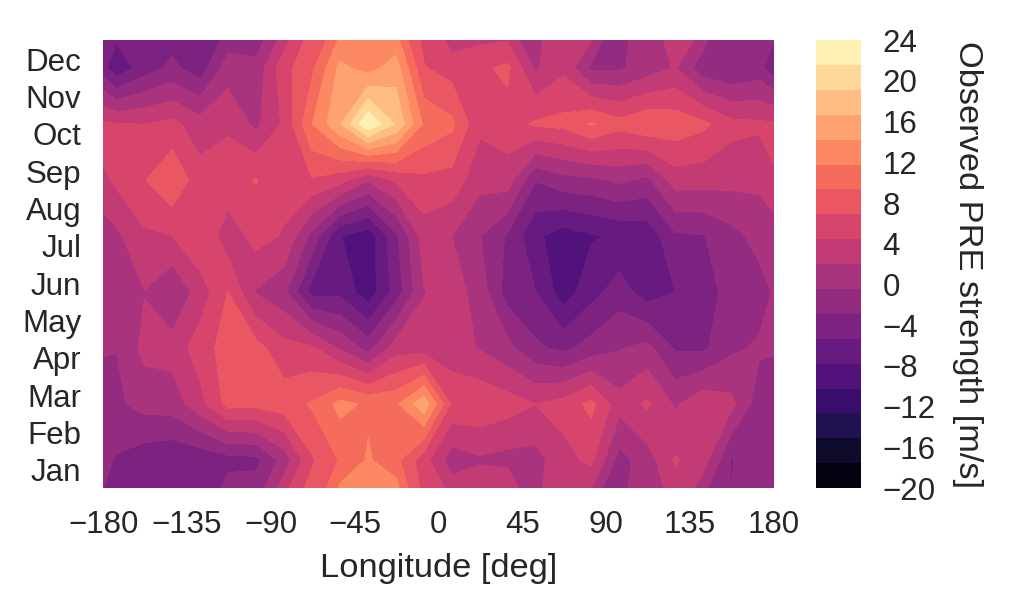

In [57]:
### With same colorbar

cmap = 'magma'

das = [ds.ivm_amp, ]
titles = ['IVM Data',]


cmin = -20
cmax = 24

for i in range(len(das)):
    
    plt.figure(figsize=(5,3.0), dpi=250)
    
    da = das[i]
        
    doybfull, lonbfull, pfull = torus(da)
    plt.contourf(lonbfull, doybfull, pfull, cmap=cmap, levels=np.linspace(cmin,cmax,19))
    plt.xlabel('Longitude [deg]')
    # plt.ylabel('Day of year')
    plt.yticks(15 + 30.5*np.arange(12), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    plt.xticks(np.arange(-180,181,45))
    plt.ylim((0,366)) # Force edges so not to repeat data
    plt.xlim((-180,180)) # Force edges so not to repeat data
    cb = plt.colorbar(label='Observed PRE strength [m/s]', aspect=10)
    cb.ax.yaxis.label.set_rotation(-90)
    cb.ax.yaxis.labelpad = 15  # Adjust the padding as needed

    cb.set_ticks(np.arange(cmin,cmax+0.1, 4))
    # cb.set_ticks([-10,0,10,20,30,40])
    plt.clim(cmin,cmax)
#     plt.title(titles[i])
    if i>0:
        ri = xr.corr(da, ds.ivm_amp)
        plt.text(175,360,r'$r=%+.2f$' % (ri), color='w', va='top',ha='right')
#     s = da.std().item()
#     plt.text(175,335,r'$\sigma=%.1f$ m/s' % (s), color='w', va='top',ha='right')
    
    plt.tight_layout()
# plt.savefig('/home/bharding/public_html/papers/Harding2024_PRE/figs/ivm_pre.pdf', bbox_inches='tight')


In [58]:
#### Construct Taylor diagram info
drivers = ['wsg_cr_hr', 'ws_cr_hr', 'wg_cr_hr', 'wr_cr_hr']
corr = xr.corr(ds.ivm_amp, ds.mod_amp, dim=['doy','lon']).sel(driver=drivers)
th = np.arccos(corr)
sig = ds.mod_amp.std(dim=['doy','lon']).sel(driver=drivers)
sig_dat = ds.ivm_amp.std()

In [59]:
### Define some helper functions for plotting

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches
from matplotlib.patches import Wedge

def partially_filled_circle(ax, r, theta, radius, color, th0, dth):
    # Create a half-filled circle (a wedge covering 180 degrees)
    # Assumes inputs are polar coordinates
    
    x, y = r * np.cos(theta), r * np.sin(theta)
    
    wedge = Wedge((x, y), radius, th0, th0+dth, facecolor=color, edgecolor='black', transform=ax.transData._b, clip_on=False)
    ax.add_patch(wedge)
    
    # Plot the outline of the circle
    circle = plt.Circle((x, y), radius, edgecolor='black', facecolor='none', transform=ax.transData._b, clip_on=False)
    ax.add_patch(circle)
    
def circle_with_letter(ax, r, theta, radius, text='', textsize=10):
    
    # Assumes inputs are polar coordinates
    
    x, y = r * np.cos(theta), r * np.sin(theta)
    
#     wedge = Wedge((x, y), radius, th0, th0+dth, facecolor=color, edgecolor='black', transform=ax.transData._b, clip_on=False)
#     ax.add_patch(wedge)
    
    # Plot the outline of the circle
    circle = plt.Circle((x, y), radius, edgecolor='black', facecolor='none', transform=ax.transData._b, clip_on=False)
    ax.add_patch(circle)
    
    ax.text(x, y, text, horizontalalignment='center', verticalalignment='center', fontsize=textsize, transform=ax.transData._b, )

    
def setup_taylor(ax, sref=1.0, snorm=True, fs = 10, plot_star=True):
    '''
    ax = axis, created with polar=True
    smax = max standard deviation to show
    snorm = True if normalized stddevs are used (this affects xlabel only)
    fs = fontsize
    '''
    
    smax = 1.1*sref # This should probably work fine
    
    # Set limits and tick locations
    cticks = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0]
    thticks = np.arccos(cticks)*180/np.pi
    thticklabels = ['%.1f'%c for c in cticks]
    ax.set_thetagrids(thticks, thticklabels)
    ax.set_thetamin(0)
    ax.set_thetamax(90)
    # ax.set_rticks(np.arange(0.0, smax+0.01, 0.2));
    ax.tick_params(axis='both', which='major', labelsize=fs)

    # Axis Labels
    # rlab  = plt.text(0.5, smax/2, 'Standard deviation (normalized)', fontsize=fs, va='center', ha='center')
    if snorm:
        plt.xlabel('Standard deviation (normalized)', fontsize=fs, labelpad=15)
    else:
        plt.xlabel('Standard deviation [m/s]', fontsize=fs, labelpad=15)
    thlab = plt.text(np.pi/4, 1.1*smax, 'Correlation', fontsize=fs, va='center', ha='center', rotation=-45)

    # Add error contours
    levels = 5
    rs, ths = np.meshgrid(np.linspace(0.0,smax),
                         np.linspace(0, np.pi/2.))
    s1 = rs # Map these to sigma and correlation
    s2 = sref
    rho = np.cos(ths)
    rms = np.sqrt(s1**2 + s2**2 - 2*s1*s2*rho) # Law of cosines == rms formula (ignoring bias)
    contours = ax.contour(ths, rs, rms, levels, colors=[[0.4,0.4,0.4]], linewidths=0.5, linestyles='dashed')
    ax.clabel(contours, fontsize=fs-3, use_clabeltext=True, fmt='%.1f')
    
    # Plot target
    if plot_star:
        plt.plot(0.0, sref, 'k*', clip_on=False, ms=20)
    
 

In [60]:
def arrow(start_theta, start_r, end_theta, end_r, connectionstyle, head_length=5, head_width=3):
    # Convert polar coordinates to Cartesian coordinates
    start_x, start_y = start_r * np.cos(start_theta), start_r * np.sin(start_theta)
    end_x, end_y = end_r * np.cos(end_theta), end_r * np.sin(end_theta)

    # Create a curved arrow using FancyArrowPatch
    arrowstyle = patches.ArrowStyle("->", head_length=head_length, head_width=head_width)
    curved_arrow = patches.FancyArrowPatch((start_x, start_y), (end_x, end_y),
                                           connectionstyle=connectionstyle,
                                           arrowstyle=arrowstyle,
                                           color='black',
                                           transform=ax.transData._b,
                                           lw=1)
    ax.add_patch(curved_arrow)

<IPython.core.display.Javascript object>


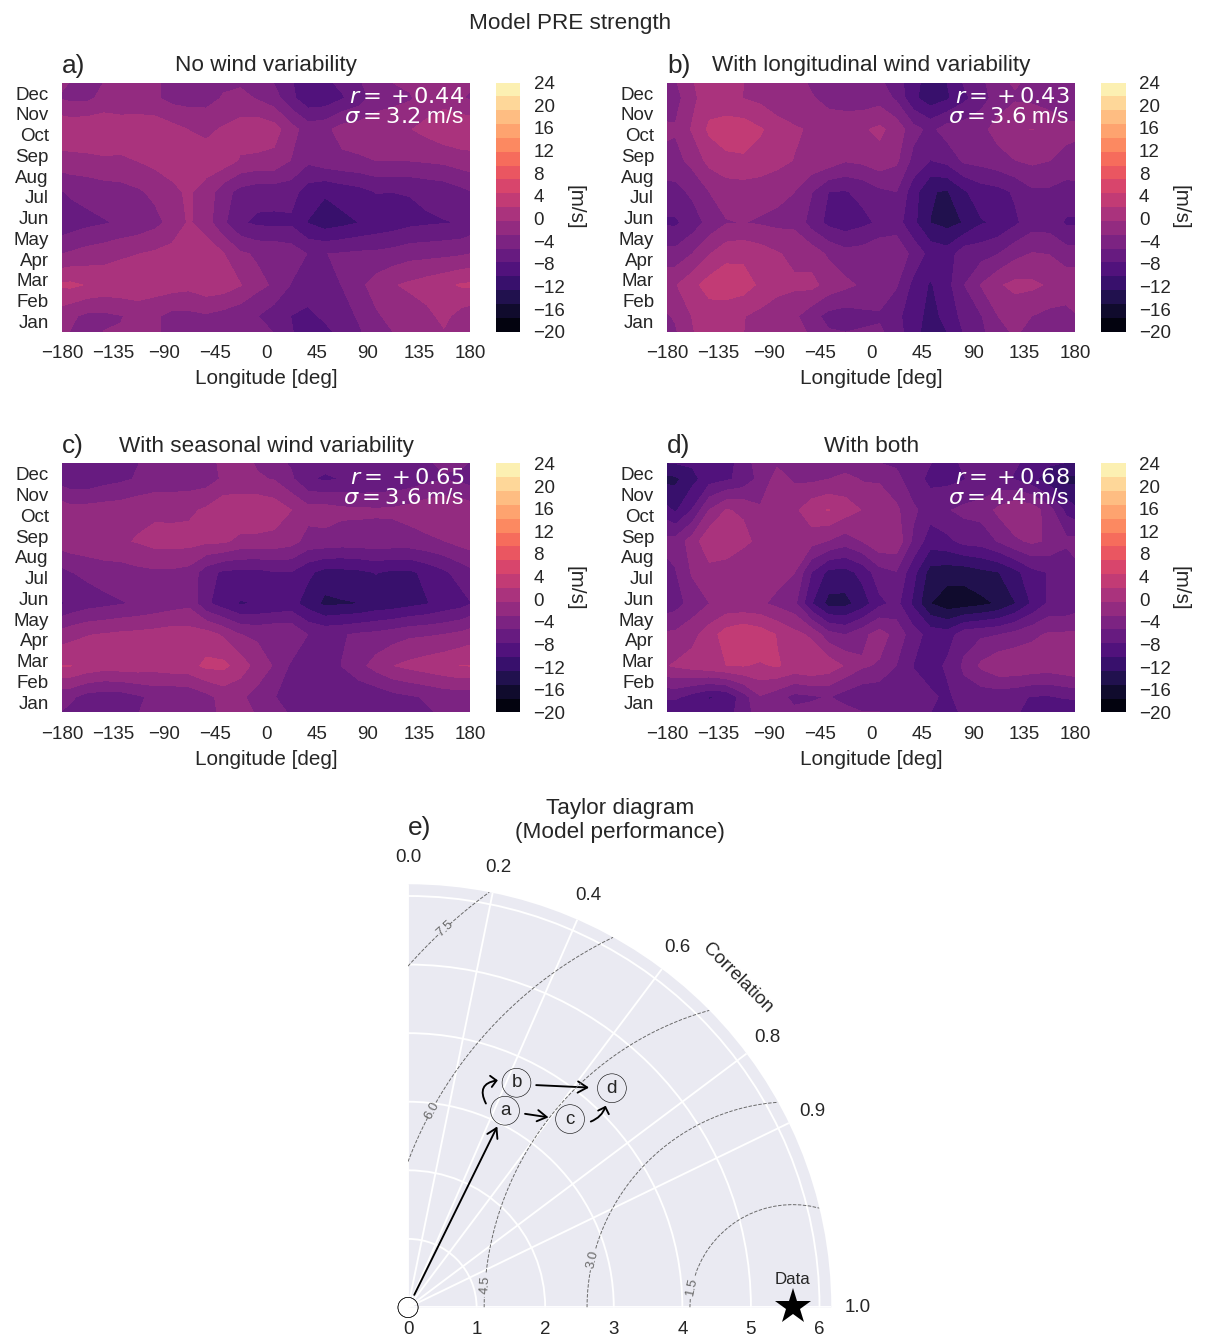

In [61]:

import matplotlib.gridspec as gridspec

####### MODEL RESULTS #########

cmap = 'magma'

das = [
       ds.mod_amp.sel(driver='wsg_cr_hr'),
       ds.mod_amp.sel(driver='ws_cr_hr'),
       ds.mod_amp.sel(driver='wg_cr_hr'),
       ds.mod_amp.sel(driver='wr_cr_hr'),]
titles = [
          'No wind variability',
          'With longitudinal wind variability',
          'With seasonal wind variability',
          'With both',
         ]


cmin = -20
cmax = 24

fig = plt.figure(figsize=(10,11.0), dpi=150)
gs = gridspec.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1.7])

for i in range(len(das)):
    
    ax = fig.add_subplot(gs[i])
#     plt.subplot(2,2,i+1)
    da = das[i]
      
    doybfull, lonbfull, pfull = torus(da)
    plt.contourf(lonbfull, doybfull, pfull, cmap=cmap, levels=np.linspace(cmin,cmax,19))
    plt.xlabel('Longitude [deg]')
    # plt.ylabel('Day of year')
    plt.yticks(15 + 30.5*np.arange(12), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    plt.xticks(np.arange(-180,181,45))
    plt.ylim((0,366)) # Force edges so not to repeat data
    plt.xlim((-180,180)) # Force edges so not to repeat data
    cb = plt.colorbar(label='[m/s]', aspect=10)
    cb.ax.yaxis.label.set_rotation(-90)
    cb.ax.yaxis.labelpad = 10  # Adjust the padding as needed

    cb.set_ticks(np.arange(cmin,cmax+0.1, 4))
    # cb.set_ticks([-10,0,10,20,30,40])
    plt.clim(cmin,cmax)
#     plt.title(titles[i])
    ri = xr.corr(da, ds.ivm_amp)
    plt.text(175,360,r'$r=%+.2f$' % (ri), color='w', va='top',ha='right', fontsize=12)
    s = da.std().item()
    plt.text(175,330,r'$\sigma=%.1f$ m/s' % (s), color='w', va='top',ha='right', fontsize=12)
    plt.title(titles[i])
    plt.text(0.00, 1.02, ['a)','b)','c)','d)'][i], ha='left',  va='bottom', transform=plt.gca().transAxes, fontsize=14)

    
    
##### TAYLOR ####  
radius = 0.21

ax = fig.add_subplot(gs[2,:], polar=True)

sref = sig_dat.item()

# Saved for later: computation for error in correlation:
# corerr = sqrt(1-cplot**2)/(sqrt(samps-2))

setup_taylor(ax, snorm=False, sref=sref)

plt.sca(ax)


partially_filled_circle(ax, 0, 0, radius*0.7, 'none', 90, 360)
# plt.plot(0, 0, 'wo', clip_on=False, ms=10, mew=0.5, mec='k')

d = 'wsg_cr_hr'
# partially_filled_circle(ax, sig.sel(driver=d), th.sel(driver=d), radius, 'none', 90, 180)
circle_with_letter(ax, sig.sel(driver=d), th.sel(driver=d), radius, 'a')
arrow(th.sel(driver=d).item(), 0.15, th.sel(driver=d).item(), sig.sel(driver=d).item()-0.2, 'arc3,rad=0.0')

d = 'ws_cr_hr'
# partially_filled_circle(ax, sig.sel(driver=d), th.sel(driver=d), radius, 'C0', 90, 180)
circle_with_letter(ax, sig.sel(driver=d), th.sel(driver=d), radius, 'b')
arrow(th.sel(driver='wsg_cr_hr').item()+0.08, sig.sel(driver='wsg_cr_hr').item()-0.05, th.sel(driver=d).item()+0.06, sig.sel(driver=d).item()-0.05, 'arc3,rad=-0.8', head_length=3)


d = 'wg_cr_hr'
# partially_filled_circle(ax, sig.sel(driver=d), th.sel(driver=d), radius, 'C1', 270, 180)
circle_with_letter(ax, sig.sel(driver=d), th.sel(driver=d), radius, 'c')
arrow(th.sel(driver='wsg_cr_hr').item()-0.07, sig.sel(driver='wsg_cr_hr').item()+0.08, th.sel(driver=d).item()+0.06, sig.sel(driver=d).item()-0.15, 'arc3,rad=-0.0', head_length=5)


d = 'wr_cr_hr'
# partially_filled_circle(ax, sig.sel(driver=d), th.sel(driver=d), radius, 'C0', 90, 180)
circle_with_letter(ax, sig.sel(driver=d), th.sel(driver=d), radius, 'd')
arrow(th.sel(driver='ws_cr_hr').item()-0.06, sig.sel(driver='ws_cr_hr').item()+0.08, th.sel(driver=d).item()+0.05, sig.sel(driver=d).item()-0.18, 'arc3,rad=-0.0', head_length=5)

# partially_filled_circle(ax, sig.sel(driver=d), th.sel(driver=d), radius, 'C1', 270, 180)
arrow(th.sel(driver='wg_cr_hr').item()-0.06, sig.sel(driver='wg_cr_hr').item()+0.13, th.sel(driver=d).item()-0.02, sig.sel(driver=d).item()-0.2, 'arc3,rad=+0.3', head_length=3)

plt.text(0.06,sref,'Data', ha='center', fontsize=9)
plt.text(0.00, 1.105, 'e)', ha='left',  va='bottom', transform=plt.gca().transAxes, fontsize=14)
plt.title('Taylor diagram\n(Model performance)')


plt.gcf().suptitle('Model PRE strength', x=0.47, y=0.99)
plt.tight_layout(h_pad=0, w_pad=2)

# Manual adjustments. This makes it look bad in ipynb but ok when saved.
pos2 = ax.get_position()  # Get the original position
pos2.y0 -= 0.03  # Lower the bottom y-position by 0.1
pos2.y1 -= 0.03  # Lower the top y-position by 0.1
ax.set_position(pos2)  # Set the new position
    

# plt.savefig('/home/bharding/public_html/papers/Harding2024_PRE/figs/model_pre.pdf', bbox_inches='tight')



In [62]:
# Report mean values
print('Data mean: %.2f m/s' % (ds.ivm_amp.mean().item()))
for da in das:
    print('%s Mean: %.2f m/s' % (da.driver.item(), da.mean().item()))
    print('\t\t\tBias: %.2f m/s' % (da.mean().item() - ds.ivm_amp.mean().item()))

Data mean: 2.45 m/s
wsg_cr_hr Mean: -3.21 m/s
			Bias: -5.65 m/s
ws_cr_hr Mean: -3.85 m/s
			Bias: -6.30 m/s
wg_cr_hr Mean: -4.12 m/s
			Bias: -6.57 m/s
wr_cr_hr Mean: -5.15 m/s
			Bias: -7.60 m/s


In [31]:
# RE = 6731
# hR = 90
# h = 750
# 180./np.pi * np.arccos(np.sqrt((RE+hR)/(RE+h)))